In [15]:
import os
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile

import random as rnd
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
from matplotlib.text import Annotation


<function matplotlib.pyplot.show(*args, **kw)>

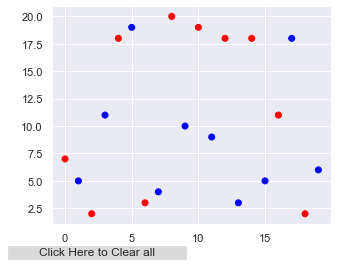

In [19]:
labels_color_map = {0: 'red', 1: "blue"}
no_examples = 20

generated_data = [(x, rnd.randint(0, no_examples)) for x in range(0, no_examples)]
generated_labels = ["Label for instance #{0}".format(i) for i in range(0, no_examples)]

instances_colors = []
axis_values_x = []
axis_values_y = []

for index, instance in enumerate(generated_data):
    coordinate_x, coordinate_y = instance
    color = labels_color_map[index % 2]
    
    instances_colors.append(color)
    axis_values_x.append(coordinate_x)
    axis_values_y.append(coordinate_y)
    
fig = plt.figure(figsize=(5,4))
ax = plt.subplot()

def draw_scatterplot():
    ax.scatter(
        axis_values_x,
        axis_values_y,
        c=instances_colors,
        picker=True
    )

draw_scatterplot()
    
# def annotate(axis, text, x,y):
#     text_annotation = Annotation(text, xy=(x,y), xycoords="data")
#     axis.add_artist(text_annotation)
    
# annotate(axis, text, x,y)
    
def onpick(event):
    ind = event.ind
    label_pos_x = event.mouseevent.xdata
    label_pos_y = event.mouseevent.ydata
    offset = 0
    
    for i in ind:
        label = generated_labels[i]
        print("index", i, label)
        annotate(
            ax,
            label,
            label_pos_x + offset,
            label_pos_y + offset)
        ax.figure.canvas.draw_idle()
        offset += 0.01

        
fig.canvas.mpl_connect('button_press_event', onpick)


ax_clear_all = plt.axes([0.0, 0.0, 0.5, 0.05])
button_clear_all = Button(ax_clear_all, "Click Here to Clear all")

def onclick(event):
    ax.cla
    draw_scatterplt()
    ax.figure.canvas.draw_idle()
    
button_clear_all.on_clicked(onclick)

plt.plot()
plt.show